All the import statements in one cell.

In [1]:
import json
import pickle
import gc
import glob
import re
import tarfile
from datetime import datetime, timezone
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import dask.bag as db
import dask.distributed

from hist import Hist

Use all my cores, even though what I want to do is pure Python. (Dask Bag!)

In [2]:
client = dask.distributed.Client(n_workers=8, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 62.10 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38647,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 62.10 GiB
Comm: tcp://127.0.0.1:37519,Total threads: 1
Dashboard: http://127.0.0.1:45265/status,Memory: 7.76 GiB
Nanny: tcp://127.0.0.1:41953,


Only need to do this if `/tmp/*` is out of date, not every time the notebook gets relaunched.

In [3]:
cmssw_file_ages = list(json.load(open("/home/jpivarski/storage/data/physicists/forks-of-cmssw-2023-02-13/file-ages.json")).items())

In [4]:
len(cmssw_file_ages)

22961

In [5]:
start = stop = 0
for i in range(100):
    stop = min(stop + int(np.ceil(len(cmssw_file_ages) / 100)), len(cmssw_file_ages))
    pickle.dump(dict(cmssw_file_ages[start:stop]), open(f"/tmp/cmssw-file-ages-{i}.pkl", "wb"))
    start = stop

In [6]:
root_file_ages = list(json.load(open("/home/jpivarski/storage/data/physicists/github-archive/file-ages.json")).items())

In [7]:
len(root_file_ages)

17334

In [8]:
start = stop = 0
for i in range(100):
    stop = min(stop + int(np.ceil(len(root_file_ages) / 100)), len(root_file_ages))
    pickle.dump(dict(root_file_ages[start:stop]), open(f"/tmp/root-file-ages-{i}.pkl", "wb"))
    start = stop

Start here if relaunching the notebook.

In [9]:
cmssw_file_ages_names = db.from_sequence([f"/tmp/cmssw-file-ages-{i}.pkl" for i in range(100)])
root_file_ages_names = db.from_sequence([f"/tmp/root-file-ages-{i}.pkl" for i in range(100)])

## Question 1

Some repos are clearly copy-pasted, like private copies of CMSSW. Do we see that as a spike of many files with nearly identical ages?

In [4]:
def calculate_num_files_std_age(filename):
    gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = {}
    for name, repo in batch.items():
        ages = []
        for file, data in repo.items():
            try:
                ages.append(datetime.strptime(data[0], "%Y-%m-%d %H:%M:%S %z").timestamp()/60/60/24)
            except ValueError:
                pass
        out[name] = {"num_files": len(ages), "std_age": np.std(ages) if len(ages) != 0 else 0.0}
    return out

In [5]:
num_files_std_age = cmssw_file_ages_names.map(calculate_num_files_std_age)

In [6]:
num_files_std_age = num_files_std_age.compute()

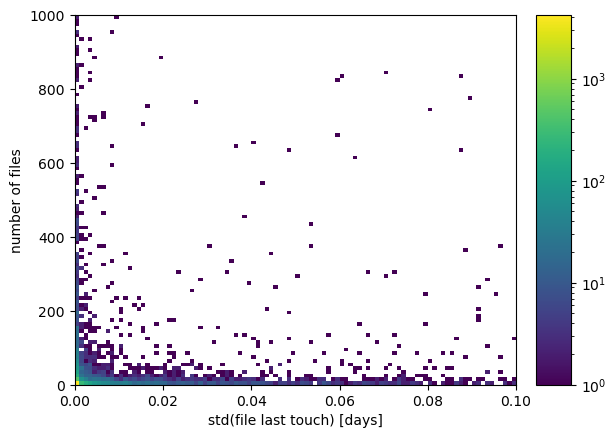

In [21]:
fig, ax = plt.subplots(1, 1)

Hist.new.Reg(100, 0, 0.1, name="std(file last touch) [days]").Reg(100, 0, 1000, name="number of files").Double().fill(
    [data["std_age"] for batch in num_files_std_age for name, data in batch.items()],
    [data["num_files"] for batch in num_files_std_age for name, data in batch.items()],
).plot(ax=ax, norm=matplotlib.colors.LogNorm());

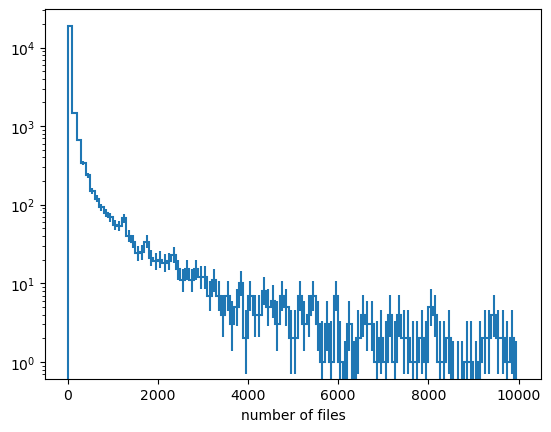

In [52]:
fig, ax = plt.subplots(1, 1)

Hist.new.Reg(100, 0, 10000, name="number of files").Double().fill(
    [data["num_files"] for batch in num_files_std_age for name, data in batch.items()],
).plot(ax=ax);

ax.set_yscale("log");

In [67]:
num_files_std_age = root_file_ages_names.map(calculate_num_files_std_age)

In [68]:
num_files_std_age = num_files_std_age.compute()

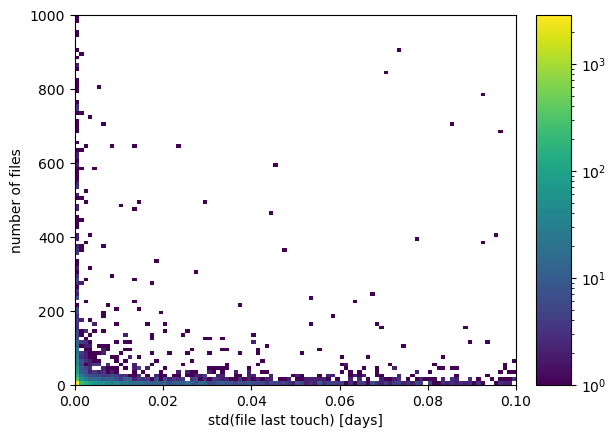

In [69]:
fig, ax = plt.subplots(1, 1)

Hist.new.Reg(100, 0, 0.1, name="std(file last touch) [days]").Reg(100, 0, 1000, name="number of files").Double().fill(
    [data["std_age"] for batch in num_files_std_age for name, data in batch.items()],
    [data["num_files"] for batch in num_files_std_age for name, data in batch.items()],
).plot(ax=ax, norm=matplotlib.colors.LogNorm());

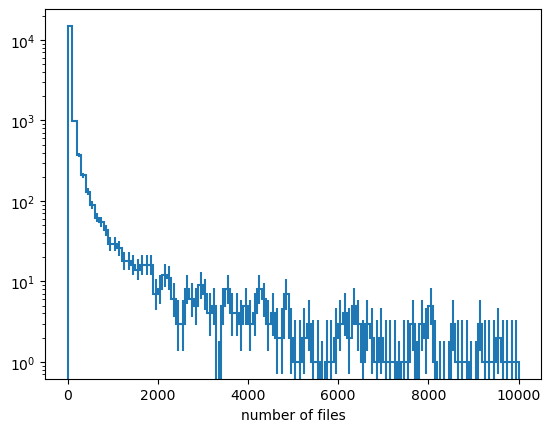

In [71]:
fig, ax = plt.subplots(1, 1)

Hist.new.Reg(100, 0, 10000, name="number of files").Double().fill(
    [data["num_files"] for batch in num_files_std_age for name, data in batch.items()],
).plot(ax=ax);

ax.set_yscale("log");

In [27]:
extremes = [[name, data["num_files"]] for batch in num_files_std_age for name, data in batch.items() if data["num_files"] > 100]
extremes.sort(key=lambda x: x[1])
extremes[-10:]

[['jsiado/Wprime', 95746],
 ['mpresill/VBS_unitarity', 96324],
 ['AnYpku/PKU-Cluster', 109450],
 ['hbprosper/CI8TeV', 111691],
 ['emcannaert/FNALLPC', 128210],
 ['sciencecw/AI4code_Erdos_2022', 140678],
 ['cmstas/DataTuple-backup', 163192],
 ['hrishikeshgoyal/NetBSD-kernel-source', 175535],
 ['tvami/HSCPbackgroundPred', 196789],
 ['mialiu149/fpixphase1', 314795]]

**Answer to question 1:** After looking at these repos, they also copied some of the git history, so that's why we don't see a lot of files with the same age.

They do need to be cut out somehow, though. Maybe just number of files.

In [53]:
def calculate_repos_with_few_files(filename):
    gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = 0
    for name, repo in batch.items():
        if len(repo) < 1000:
            out += 1
    return out

In [54]:
cmssw_file_ages_names.map(calculate_repos_with_few_files).sum().compute() / 22961

0.958364182744654

In [55]:
root_file_ages_names.map(calculate_repos_with_few_files).sum().compute() / 17334

0.9700588438906196

In [65]:
def calculate_names_of_repos_with_few_files(filename):
    gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = []
    for name, repo in batch.items():
        if len(repo) < 10000:
            out.append([name, len(repo)])
    out.sort(key=lambda x: x[1])
    return out[-1]   # show the most borderline cases

In [66]:
sorted(cmssw_file_ages_names.map(calculate_names_of_repos_with_few_files).compute(), key=lambda x: x[1])[-10:]

[['waredjeb/graviton-analysis', 9454],
 ['scooperstein/CMSSW_5_3_3', 9462],
 ['choij1589/ChargedHiggsAnalysis', 9497],
 ['rappoccio/usercode', 9503],
 ['mobassirameen/BsPi-Analysis', 9578],
 ['FHead/PhysicsEEJet', 9603],
 ['lsoffi/SherpaHggInterference', 9640],
 ['ramankhurana/HGCALTBAnalysis', 9760],
 ['cranelli/GenProductions', 9805],
 ['SiewYan/Genprod2', 9840]]

In [72]:
sorted(root_file_ages_names.map(calculate_names_of_repos_with_few_files).compute(), key=lambda x: x[1])[-10:]

[['LucaZampieri/myDotfiles', 9131],
 ['ViralTaco/Exercism-Solutions', 9164],
 ['parikshit223933/Kaggle', 9207],
 ['davidwed/cegcc-gcc', 9309],
 ['xywei/dealii-docset', 9557],
 ['philr1976/limbo-android', 9570],
 ['andriish/rivet', 9636],
 ['redeboer/BOSS_ExternalLibs', 9778],
 ['Alessandro-Barbieri/node-overlay', 9850],
 ['Aniq55/DSS_src', 9978]]

## Cut against fake forks

For repos bigger than 10000 (top 10% or so), we get the list of all contributors. For these big repos, we want to exclude repos in which the owner did not contribute the most commits.

In [10]:
cmssw_repo_fraction_commits = {}
for filename in glob.glob("/home/jpivarski/storage/data/physicists/forks-of-cmssw-2023-02-13/user-repos-contributors/*.json"):
    reponame = filename[90:-5].replace("__", "/")
    if reponame == "Abdoelabassi/Quantum/qiskit/Starter":
        reponame = "Abdoelabassi/Quantum__qiskit__Starter"
    assert reponame.count("/") == 1, reponame
    owner = reponame[:reponame.index("/")]
    filedata = open(filename).read()
    if len(filedata.strip()) == 0:
        cmssw_repo_fraction_commits[reponame] = 0.0
    else:
        contributors = json.loads(filedata)
        if isinstance(contributors, dict) and contributors["message"] in ("Moved Permanently", "Not Found", "Repository access blocked"):
            cmssw_repo_fraction_commits[reponame] = 0.0
        else:
            total_commits = sum(x["contributions"] for x in contributors)
            if total_commits == 0:
                cmssw_repo_fraction_commits[reponame] = 1.0
            else:
                cmssw_repo_fraction_commits[reponame] = sum(x["contributions"] for x in contributors if x["login"] == owner) / total_commits

In [11]:
root_repo_fraction_commits = {}
for filename in glob.glob("/home/jpivarski/storage/data/physicists/github-archive/root-repo-user-repos-contributors/*.json"):
    reponame = filename[89:-5].replace("__", "/")
    assert reponame.count("/") == 1, reponame
    owner = reponame[:reponame.index("/")]
    contributors = json.load(open(filename))
    if isinstance(contributors, dict) and contributors["message"] in ("The history or contributor list is too large to list contributors for this repository via the API.", "Not Found", "Repository access blocked"):
        root_repo_fraction_commits[reponame] = 0.0
    else:
        total_commits = sum(x["contributions"] for x in contributors)
        if total_commits == 0:
            root_repo_fraction_commits[reponame] = 1.0
        else:
            root_repo_fraction_commits[reponame] = sum(x["contributions"] for x in contributors if x["login"] == owner) / total_commits

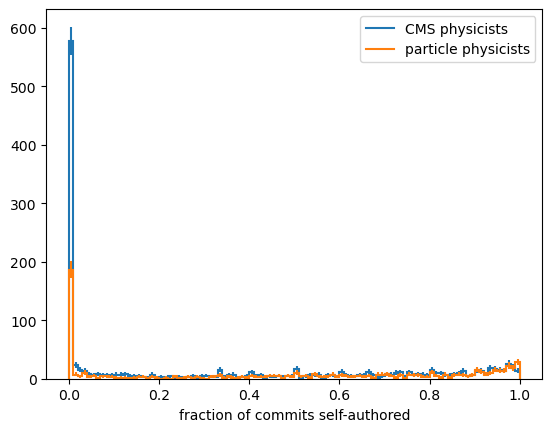

In [12]:
fig, ax = plt.subplots(1, 1)

Hist.new.Reg(100, 0, 1, name="fraction of commits self-authored").Double().fill(
    list(cmssw_repo_fraction_commits.values())
).plot(ax=ax)

Hist.new.Reg(100, 0, 1, name="fraction of commits self-authored").Double().fill(
    list(root_repo_fraction_commits.values())
).plot(ax=ax)

ax.legend(["CMS physicists", "particle physicists"]);

In [13]:
cmssw_repo_exclude = {name for name, fraction in cmssw_repo_fraction_commits.items() if fraction < 0.01}
root_repo_exclude = {name for name, fraction in root_repo_fraction_commits.items() if fraction < 0.01}

In [14]:
len(cmssw_repo_exclude), len(root_repo_exclude)

(577, 186)

This will be easy: **exclude** any repos bigger than 10000 (GitHub's estimation; only the top 10%) for which fewer than 1% of the commits are self-authored.

It's not very many, but it probably represents a lot of files. Now I can make plots that scale with the number of files.

Names of those repos (revealing that this also catches org accounts):

In [15]:
cmssw_repo_exclude

{'4quarks/usercode',
 'AdrianAlan/L1Trigger_VAE',
 'AlbertHsuNTUphys/ChargeFlipStudy',
 'AlbertHsuNTUphys/Hello-word',
 'Alex2671/drivemenu.github.io',
 'AlexandreMertens/WingTsunNamur',
 'AlexandreMertens/website',
 'AlexandreMertens/wingtsunwallonie',
 'AnYpku/cmssw10x',
 'AndreasAlbert/genprod2',
 'AndreasAlbert/genprodCards',
 'Axel-Naumann/clang',
 'Axel-Naumann/llvm',
 'BParkHNLs/HNLsGen',
 'BaylorCMS/HCALTB2015',
 'BaylorCMS/HcalPromptAnalysis',
 'BaylorCMS/HcalRelVal',
 'BetterWang/g4e',
 'CERN-PH-CMG/cmg-cmssw',
 'CERN-PH-CMG/cmgtools-lite',
 'CJLST/ZZAnalysis',
 'CMS-HGCAL/TestBeam',
 'CMS-HGCAL/reco-ntuples',
 'CMS-HIN-dilepton/DimuonCADIs',
 'CMS-HIN-dilepton/Dimuons',
 'CMS-HTT/2015-sync',
 'CMS-HTT/CorrectionsWorkspace',
 'CMS-LUMI-POG/BeamImaging',
 'CMS-LUMI-POG/PCCTools',
 'CMS-LUMI-POG/VdMFramework',
 'CMS-LUMI-POG/ZCounting',
 'CMSDIJET/DarkMatterInterpretation',
 'CMSDIJET/DijetLimitCode',
 'CMSDIJET/DijetRootTreeAnalyzer',
 'CMSDIJET/DijetShapeInterpolator',
 'CMSL

In [16]:
root_repo_exclude

{'38tter/haniwa-dogu-recognition',
 'AaronBallman/tra-working',
 'AlejandroJL/mp4parser',
 'AnYpku/cmssw10x',
 'Axel-Naumann/clang',
 'Axel-Naumann/llvm',
 'ChristopherRabotin/GMAT',
 'Daniel-Dane/DetectorCourse_CanDetector',
 'Eideticom/docker-noload',
 'Eideticom/eid-hermes-qemu',
 'ElsevierSoftwareX/PyScratch',
 'ElsevierSoftwareX/SOFTX-D-15-00003',
 'JarlPed/ase',
 'Joonpark13/structify',
 'LSchwiebert/GOMC_GPU',
 'LeCastorFou/PARCweb',
 'LucasReSilva/MeuPrimeiroAppSwift',
 'Noflare/wavvy-medusa',
 'PetrilloAtWork/dunetpc',
 'RTSYork/BlueIO',
 'RTSYork/MrsP_Implementation_Litmus',
 'RTSYork/RTSScreen',
 'RTSYork/Real-Time-Stream-Processing',
 'RTSYork/airtight',
 'RTSYork/linux-4.1.15-rt17-profiling',
 'Teemperor/cif',
 'Teemperor/clang-dump',
 'UWCNuclear/Geant4Scintillator',
 'VRanger/FastHub',
 'VRanger/LH_Kernel',
 'VRanger/dragontc-7.0',
 'VRanger/quantum',
 'aannabe/accurate_energies',
 'aannabe/chk_files',
 'aannabe/diamond_si',
 'aannabe/si_molecules',
 'aarongrisez/Mantico

In [31]:
# These take a long time to compute and they aren't physics related.
root_repo_exclude.add("GuacheSuede/MSCVProject")
root_repo_exclude.add("GuacheSuede/MSSubmission1234567890")

## Question 2

Top includes and imports in what remains, to see if we can characterize all ".py" files as "Python" now, or if we still have to cut against CMSSW configurations.

In [17]:
cmssw_repo_dir = "/home/jpivarski/storage/data/GitHub-CMSSW-user-nonfork-raw-data-1Mcut"
root_repo_dir = "/home/jpivarski/storage/data/GitHub-ROOT-user-nonfork-raw-data-1Mcut"

In [18]:
def cpp_file_extension(filename):
    x = filename.lower()
    return x.endswith(".c") or x.endswith(".cc") or x.endswith(".cpp") or x.endswith(".cp") or x.endswith(".cxx") or x.endswith(".c++") or x.endswith(".h") or x.endswith(".hpp") or x.endswith(".hp") or x.endswith(".hh")

In [19]:
def python_imports(filedata):
    return set("py:" + sorted(m.groups()[1:], key=lambda x: x is None)[0].decode("utf-8") for m in re.finditer(b"^\s*(import\s+([A-Za-z_][A-Za-z_0-9]*)|from\s+([A-Za-z_][A-Za-z_0-9]*)\s+import)", filedata, re.M))

In [20]:
def cpp_includes(filedata):
    return set("c:" + sorted(m.groups()[1:], key=lambda x: x is None)[0].decode("utf-8") for m in re.finditer(b"^\s*(#include\s*<([^>]*)>|#include\s*\"([^\"]*)\")", filedata, re.M))

In [21]:
def libraries_in_repo(repo_dir, reponame):
    with tarfile.open(f"{repo_dir}/{reponame}.tgz") as repo_tgz:
        all_libraries = set()
        for info in repo_tgz:
            if info.isfile():
                filedata = repo_tgz.extractfile(info).read()

                if info.name.lower().endswith(".ipynb"):
                    try:
                        jsondata = json.loads(filedata)
                    except (json.JSONDecodeError, UnicodeDecodeError):
                        by_cells = []
                    else:
                        by_cells = [python_imports("".join(cell["source"]).encode("utf-8")) for cell in jsondata.get("cells", []) if cell["cell_type"] == "code"]
                    if len(by_cells) == 0:
                        libraries = set()
                    else:
                        libraries = set.union(*by_cells)
                        libraries = set("PY:" + x[3:] for x in libraries)  # to distinguish .ipynb from .py

                elif info.name.lower().endswith(".py"):
                    libraries = python_imports(filedata)
                    if any(x == "py:FWCore" for x in libraries):
                        libraries = set("cms:" + x[3:] for x in libraries)

                elif cpp_file_extension(info.name):
                    libraries = cpp_includes(filedata)

                else:
                    libraries = set()

                all_libraries = all_libraries.union(libraries)
    return all_libraries

In [22]:
def calculate_libraries_per_repo(filename):
    # gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = Counter()
    for reponame in batch:
        if reponame not in cmssw_repo_exclude:
            for library in libraries_in_repo(cmssw_repo_dir, reponame):
                out[library] += 1
    return out

In [23]:
batches = cmssw_file_ages_names.map(calculate_libraries_per_repo).compute()

In [24]:
library_counts = sum(batches, Counter())

In [25]:
for library, repo_count in sorted([(x, y) for x, y in library_counts.items() if x.startswith("py:") or x.startswith("PY:")], key=lambda x: -x[1])[:50]:
    print(f"{repo_count:4d} {library[3:]}")

6802 os
5273 sys
4053 ROOT
4029 numpy
3222 math
2700 time
2466 argparse
2384 re
2320 matplotlib
2148 subprocess
2064 array
1958 json
1791 glob
1789 numpy
1776 optparse
1705 matplotlib
1654 datetime
1578 pandas
1419 random
1378 collections
1273 copy
1200 pandas
1092 __future__
1066 itertools
1021 shutil
 925 logging
 885 pickle
 855 multiprocessing
 836 os
 775 string
 665 scipy
 606 pprint
 586 csv
 541 commands
 529 tensorflow
 521 operator
 513 uproot
 505 math
 470 functools
 463 urllib
 458 sys
 433 setuptools
 427 scipy
 419 httplib
 419 tempfile
 410 seaborn
 404 warnings
 400 time
 397 socket
 389 yaml


In [26]:
for library, repo_count in sorted([(x, y) for x, y in library_counts.items() if x.startswith("cms:")], key=lambda x: -x[1])[:50]:
    print(f"{repo_count:4d} {library[4:]}")

3656 FWCore
 880 os
 685 sys
 303 HLTrigger
 239 copy
 180 PhysicsTools
 179 re
 178 subprocess
 140 math
 114 pickle
  87 ROOT
  84 L1Trigger
  79 json
  76 optparse
  75 glob
  74 random
  72 EventFilter
  71 RecoTracker
  67 time
  61 commands
  58 string
  57 unittest
  54 RecoJets
  54 collections
  52 __future__
  51 RecoEgamma
  49 RecoTauTag
  49 socket
  46 RecoLocalCalo
  45 TrackingTools
  43 CalibTracker
  43 imp
  40 argparse
  35 datetime
  34 SimGeneral
  34 CondCore
  33 das_client
  31 Alignment
  29 importlib
  28 CommonTools
  28 RecoEcal
  28 Configuration
  26 DQM
  26 RecoParticleFlow
  26 FastSimulation
  26 RecoBTag
  26 RecoMET
  25 RecoHI
  25 RecoVertex
  25 itertools


In [27]:
for library, repo_count in sorted([(x, y) for x, y in library_counts.items() if x.startswith("c:")], key=lambda x: -x[1])[:50]:
    print(f"{repo_count:4d} {library[2:]}")

6896 iostream
5920 vector
5434 TFile.h
5340 string
4669 TTree.h
4482 fstream
4025 TCanvas.h
3742 TROOT.h
3718 TMath.h
3543 map
3521 sstream
3449 algorithm
3413 TStyle.h
3410 cmath
3234 memory
3135 TH1.h
3095 TH1F.h
3084 TLorentzVector.h
2893 TChain.h
2882 TString.h
2800 TH2.h
2764 iomanip
2717 FWCore/ParameterSet/interface/ParameterSet.h
2672 TF1.h
2659 FWCore/Framework/interface/MakerMacros.h
2647 FWCore/Framework/interface/Event.h
2643 TLegend.h
2551 math.h
2483 FWCore/Framework/interface/Frameworkfwd.h
2426 stdio.h
2271 TH1D.h
2259 stdlib.h
2173 TSystem.h
2153 TH2F.h
2145 FWCore/ServiceRegistry/interface/Service.h
2034 TGraph.h
1943 cstdlib
1938 TLatex.h
1888 CommonTools/UtilAlgos/interface/TFileService.h
1842 FWCore/Framework/interface/EDAnalyzer.h
1625 FWCore/Framework/interface/ESHandle.h
1607 utility
1597 TRandom3.h
1571 TH2D.h
1566 TProfile.h
1542 TGraphErrors.h
1491 DataFormats/VertexReco/interface/Vertex.h
1487 TLine.h
1454 TGraphAsymmErrors.h
1445 TPad.h


In [28]:
def calculate_libraries_per_repo(filename):
    # gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = Counter()
    for reponame in batch:
        if reponame not in root_repo_exclude:
            for library in libraries_in_repo(root_repo_dir, reponame):
                out[library] += 1
    return out

In [29]:
batches = root_file_ages_names.map(calculate_libraries_per_repo).compute()

In [30]:
library_counts = sum(batches, Counter())

In [32]:
for library, repo_count in sorted([(x, y) for x, y in library_counts.items() if x.startswith("py:") or x.startswith("PY:")], key=lambda x: -x[1])[:50]:
    print(f"{repo_count:4d} {library[3:]}")

2673 os
2231 sys
2121 numpy
1315 matplotlib
1294 time
1232 numpy
1107 re
1098 matplotlib
1019 math
1012 json
1008 argparse
 921 random
 851 datetime
 849 pandas
 800 subprocess
 756 pandas
 709 collections
 628 logging
 611 __future__
 569 setuptools
 559 glob
 527 itertools
 510 os
 503 ROOT
 502 shutil
 496 copy
 460 pathlib
 454 functools
 454 requests
 421 pickle
 420 typing
 402 scipy
 348 string
 334 multiprocessing
 321 csv
 321 threading
 306 urllib
 302 warnings
 298 unittest
 298 seaborn
 298 io
 291 tqdm
 287 math
 282 torch
 278 scipy
 276 flask
 270 tempfile
 268 array
 259 time
 256 random


In [33]:
for library, repo_count in sorted([(x, y) for x, y in library_counts.items() if x.startswith("cms:")], key=lambda x: -x[1])[:50]:
    print(f"{repo_count:4d} {library[4:]}")

 170 FWCore
  35 os
  26 sys
  14 PhysicsTools
  14 subprocess
  10 copy
  10 HLTrigger
   9 __future__
   8 random
   7 ROOT
   7 re
   6 RecoTauTag
   6 math
   6 commands
   5 unittest
   5 optparse
   5 glob
   5 json
   4 pickle
   4 TrackingTools
   4 RecoMET
   4 time
   4 RecoTracker
   4 CommonTools
   4 RecoParticleFlow
   4 JetMETCorrections
   4 socket
   4 RecoJets
   4 string
   4 getopt
   4 L1Trigger
   4 DPGAnalysis
   4 CalibTracker
   3 datetime
   3 RecoEgamma
   3 collections
   3 Utilities
   3 pdb
   3 argparse
   3 six
   3 xml
   3 EventFilter
   3 mvaPhoID_Spring16_nonTrig_V1_producer_config
   3 SimCalorimetry
   3 CondCore
   3 Alignment
   3 RecoLocalCalo
   3 DQM
   3 das_client
   2 hcalLaserEventFilter_cfi


In [34]:
for library, repo_count in sorted([(x, y) for x, y in library_counts.items() if x.startswith("c:")], key=lambda x: -x[1])[:50]:
    print(f"{repo_count:4d} {library[2:]}")

2682 iostream
2121 vector
2022 string
1712 stdio.h
1518 stdlib.h
1457 fstream
1340 algorithm
1221 string.h
1187 cmath
1132 sstream
1083 map
1063 math.h
 899 unistd.h
 868 cstdlib
 860 memory
 844 TFile.h
 763 iomanip
 694 time.h
 682 cstring
 672 stdint.h
 668 TTree.h
 666 utility
 617 TCanvas.h
 604 cassert
 603 assert.h
 602 sys/types.h
 588 cstdio
 579 stdexcept
 576 functional
 558 limits
 533 TMath.h
 531 TROOT.h
 520 stddef.h
 507 set
 492 errno.h
 481 sys/stat.h
 469 chrono
 464 stdarg.h
 455 windows.h
 449 ctime
 448 fcntl.h
 447 TStyle.h
 445 array
 443 random
 442 TH1.h
 429 iterator
 426 TString.h
 424 limits.h
 414 list
 401 ctype.h


**Answer:** You still have to separate out FWCore. The ROOT-seeded dataset didn't show anything that looks like other experimental frameworks, though.

## Question 3

Let's make those library-adoption versus time plots again.

In [35]:
def is_root(libraries):
    return any(x in ("c:TFile.h", "c:TTree.h", "c:TCanvas.h", "c:TROOT.h", "c:TMath.h", "c:TStyle.h", "c:TH1.h", "c:TH1F.h", "c:TLorentzVector.h",
                     "c:TChain.h", "c:TString.h", "c:TH2.h", "c:TF1.h", "c:TLegend.h", "c:TH1D.h", "c:TSystem.h", "c:TH2F.h", "c:TGraph.h",
                     "c:TLatex.h", "c:TRandom3.h", "c:TH2D.h", "c:TProfile.h", "c:TGraphErrors.h", "c:TLine.h", "c:TGraphAsymmErrors.h", "c:TPad.h") for x in libraries)

In [82]:
def calculate_library_adoption_by_repo(filename):
    # gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = []
    for reponame, repo in batch.items():
        repo_date = datetime(1970, 1, 1, tzinfo=timezone.utc)
        for file, data in repo.items():
            try:
                file_date = datetime.strptime(data[0], "%Y-%m-%d %H:%M:%S %z")
            except ValueError:
                pass
            else:
                if file_date > repo_date:
                    repo_date = file_date

        if reponame not in cmssw_repo_exclude:
            libraries = libraries_in_repo(cmssw_repo_dir, reponame)
            repo = {"date": repo_date, "name": reponame}
            repo["py"] = any(x.startswith("py:") for x in libraries)
            repo["ipynb"] = any(x.startswith("PY:") for x in libraries)
            repo["cms"] = any(x.startswith("cms:") for x in libraries)
            repo["c"] = any(x.startswith("c:") for x in libraries)
            repo["c:ROOT"] = is_root(libraries)
            repo["py:ROOT"] = "py:ROOT" in libraries
            repo["py:uproot"] = "py:uproot" in libraries or "py:uproot3" in libraries or "py:uproot4" in libraries
            repo["py:awkward"] = "py:awkward" in libraries or "py:awkward0" in libraries or "py:awkward1" in libraries
            repo["py:numpy"] = "py:numpy" in libraries
            repo["py:matplotlib"] = "py:matplotlib" in libraries
            repo["py:seaborn"] = "py:seaborn" in libraries
            repo["py:pandas"] = "py:pandas" in libraries
            repo["py:scipy"] = "py:scipy" in libraries
            repo["py:tensorflow"] = "py:tensorflow" in libraries
            repo["py:torch"] = "py:torch" in libraries
            repo["py:sklearn"] = "py:sklearn" in libraries
            out.append(repo)

    return out

In [81]:
batches = cmssw_file_ages_names.map(calculate_library_adoption_by_repo).compute()

In [83]:
repodata = sum(batches, [])

df = pd.DataFrame({
    "C or C++": [x["c"] for x in repodata],
    "Python": [x["py"] for x in repodata],
    "Jupyter": [x["ipynb"] for x in repodata],
    "CMSSW config": [x["cms"] for x in repodata],
    "ROOT (C++)": [x["c:ROOT"] for x in repodata],
    "ROOT (Python)": [x["py:ROOT"] for x in repodata],
    "Uproot": [x["py:uproot"] for x in repodata],
    "Awkward Array": [x["py:awkward"] for x in repodata],
    "NumPy": [x["py:numpy"] for x in repodata],
    "Matplotlib": [x["py:matplotlib"] for x in repodata],
    "Seaborn": [x["py:seaborn"] for x in repodata],
    "Pandas": [x["py:pandas"] for x in repodata],
    "SciPy": [x["py:scipy"] for x in repodata],
    "TensorFlow": [x["py:tensorflow"] for x in repodata],
    "PyTorch": [x["py:torch"] for x in repodata],
    "Scikit-Learn": [x["py:sklearn"] for x in repodata],
}, index=[x["date"] for x in repodata])
df["Total"] = True
df["Python or Jupyter"] = df["Python"] | df["Jupyter"]
df["ROOT (any)"] = df["ROOT (C++)"] | df["ROOT (Python)"]

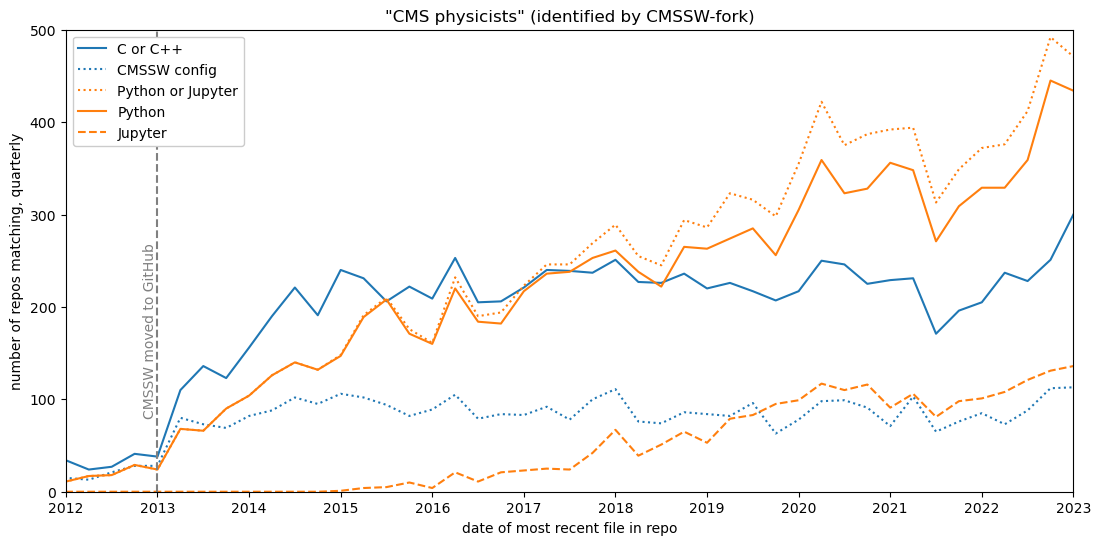

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df[["C or C++", "CMSSW config", "Python or Jupyter", "Python", "Jupyter"]].resample("Q", origin=pd.to_datetime("2013-01-01")).sum().plot(
    ax=ax,
    style=["-", ":", ":", "-", "--"],
    color=[c[0], c[0], c[1], c[1], c[1]],
);

ax.axvline(x=pd.to_datetime("2013-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2013-01-01"), 0.35, "CMSSW moved to GitHub",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 500);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_xlabel("date of most recent file in repo");
ax.set_ylabel("number of repos matching, quarterly");
ax.set_title("\"CMS physicists\" (identified by CMSSW-fork)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-language-cmsswseed.svg");
fig.savefig("github-language-cmsswseed.pdf");

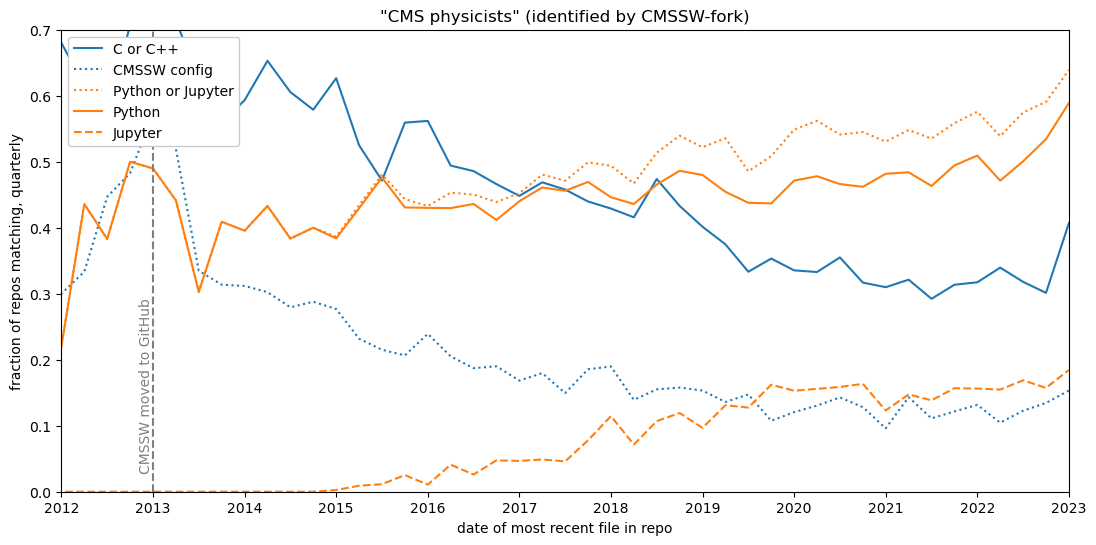

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df2 = df[["C or C++", "CMSSW config", "Python or Jupyter", "Python", "Jupyter", "Total"]].resample("Q", origin=pd.to_datetime("2013-01-01")).sum()
df2.div(df2["Total"], axis=0)[["C or C++", "CMSSW config", "Python or Jupyter", "Python", "Jupyter"]].plot(
    ax=ax,
    style=["-", ":", ":", "-", "--"],
    color=[c[0], c[0], c[1], c[1], c[1]],
);

ax.axvline(x=pd.to_datetime("2013-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2013-01-01"), 0.23, "CMSSW moved to GitHub",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 0.7);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_xlabel("date of most recent file in repo");
ax.set_ylabel("fraction of repos matching, quarterly");
ax.set_title("\"CMS physicists\" (identified by CMSSW-fork)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-language-cmsswseed-fraction.svg");
fig.savefig("github-language-cmsswseed-fraction.pdf");

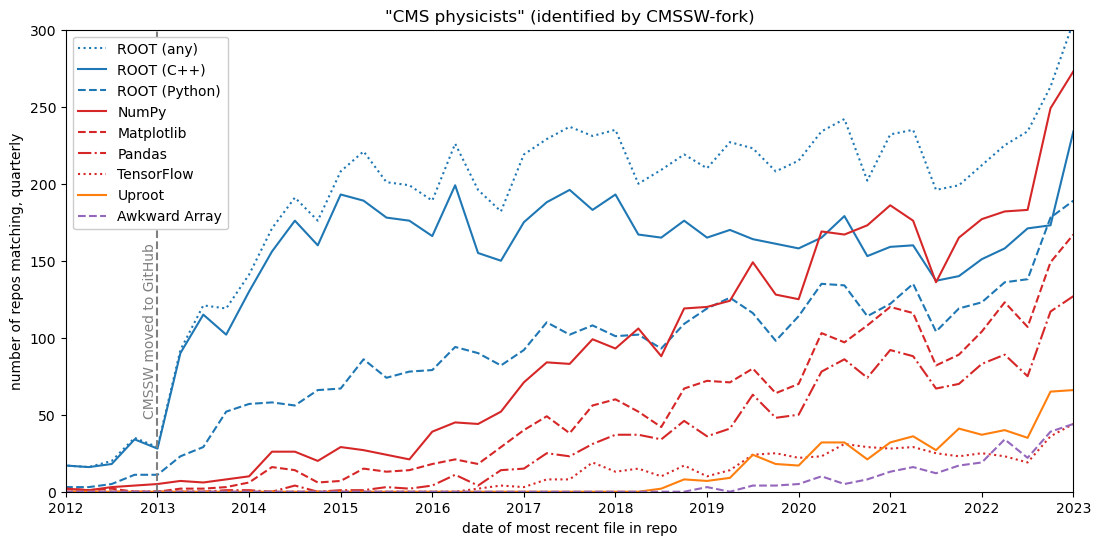

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df[["ROOT (any)", "ROOT (C++)", "ROOT (Python)", "NumPy", "Matplotlib", "Pandas", "TensorFlow", "Uproot", "Awkward Array"]].resample("Q", origin=pd.to_datetime("2013-01-01")).sum().plot(
    ax=ax,
    style=[":", "-", "--", "-", "--", "-.", ":", "-", "--"],
    color=[c[0], c[0], c[0], c[3], c[3], c[3], c[3], c[1], c[4]],
);

ax.axvline(x=pd.to_datetime("2013-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2013-01-01"), 0.35, "CMSSW moved to GitHub",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 300);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_ylabel("number of repos matching, quarterly");
ax.set_xlabel("date of most recent file in repo");
ax.set_title("\"CMS physicists\" (identified by CMSSW-fork)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-package-cmsswseed.svg");
fig.savefig("github-package-cmsswseed.pdf");

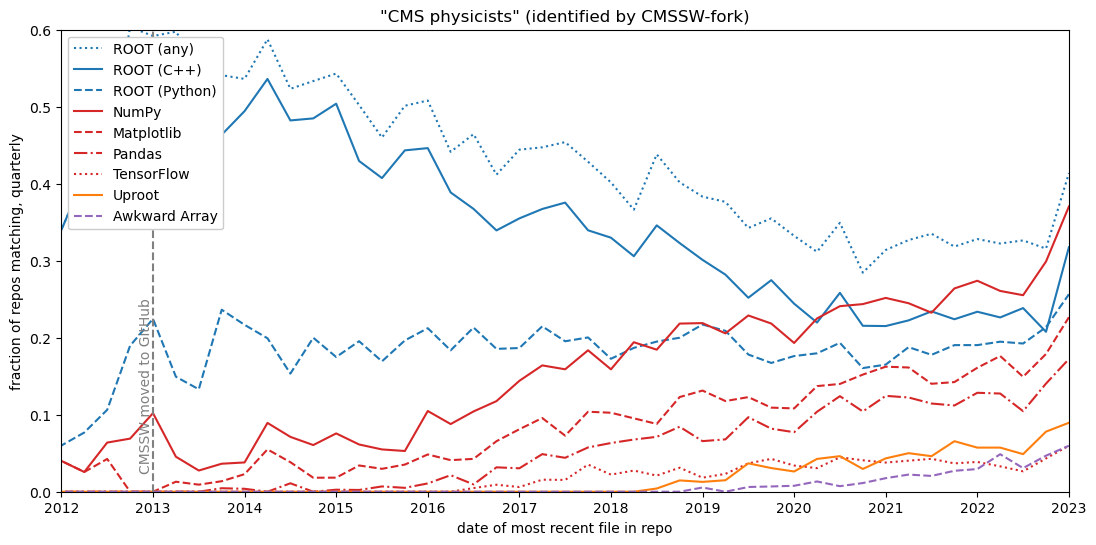

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df2 = df[["ROOT (any)", "ROOT (C++)", "ROOT (Python)", "NumPy", "Matplotlib", "Pandas", "TensorFlow", "Uproot", "Awkward Array", "Total"]].resample("Q", origin=pd.to_datetime("2013-01-01")).sum()

df2.div(df2["Total"], axis=0)[["ROOT (any)", "ROOT (C++)", "ROOT (Python)", "NumPy", "Matplotlib", "Pandas", "TensorFlow", "Uproot", "Awkward Array"]].plot(
    ax=ax,
    style=[":", "-", "--", "-", "--", "-.", ":", "-", "--"],
    color=[c[0], c[0], c[0], c[3], c[3], c[3], c[3], c[1], c[4]],
);

ax.axvline(x=pd.to_datetime("2013-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2013-01-01"), 0.23, "CMSSW moved to GitHub",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 0.6);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_ylabel("fraction of repos matching, quarterly");
ax.set_xlabel("date of most recent file in repo");
ax.set_title("\"CMS physicists\" (identified by CMSSW-fork)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-package-cmsswseed-fraction.svg");
fig.savefig("github-package-cmsswseed-fraction.pdf");

In [69]:
def calculate_library_adoption_by_repo(filename):
    # gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = []
    for reponame, repo in batch.items():
        repo_date = datetime(1970, 1, 1, tzinfo=timezone.utc)
        for file, data in repo.items():
            try:
                file_date = datetime.strptime(data[0], "%Y-%m-%d %H:%M:%S %z")
            except ValueError:
                pass
            else:
                if file_date > repo_date:
                    repo_date = file_date

        if reponame not in root_repo_exclude:
            libraries = libraries_in_repo(root_repo_dir, reponame)
            repo = {"date": repo_date, "name": reponame}
            repo["py"] = any(x.startswith("py:") for x in libraries)
            repo["ipynb"] = any(x.startswith("PY:") for x in libraries)
            repo["cms"] = any(x.startswith("cms:") for x in libraries)
            repo["c"] = any(x.startswith("c:") for x in libraries)
            repo["c:ROOT"] = is_root(libraries)
            repo["py:ROOT"] = "py:ROOT" in libraries
            repo["py:uproot"] = "py:uproot" in libraries or "py:uproot3" in libraries or "py:uproot4" in libraries
            repo["py:awkward"] = "py:awkward" in libraries or "py:awkward0" in libraries or "py:awkward1" in libraries
            repo["py:numpy"] = "py:numpy" in libraries
            repo["py:matplotlib"] = "py:matplotlib" in libraries
            repo["py:seaborn"] = "py:seaborn" in libraries
            repo["py:pandas"] = "py:pandas" in libraries
            repo["py:scipy"] = "py:scipy" in libraries
            repo["py:tensorflow"] = "py:tensorflow" in libraries
            repo["py:torch"] = "py:torch" in libraries
            repo["py:sklearn"] = "py:sklearn" in libraries
            out.append(repo)

    return out

In [70]:
batches = root_file_ages_names.map(calculate_library_adoption_by_repo).compute()

In [71]:
repodata = sum(batches, [])

df = pd.DataFrame({
    "C or C++": [x["c"] for x in repodata],
    "Python": [x["py"] for x in repodata],
    "Jupyter": [x["ipynb"] for x in repodata],
    "CMSSW config": [x["cms"] for x in repodata],
    "ROOT (C++)": [x["c:ROOT"] for x in repodata],
    "ROOT (Python)": [x["py:ROOT"] for x in repodata],
    "Uproot": [x["py:uproot"] for x in repodata],
    "Awkward Array": [x["py:awkward"] for x in repodata],
    "NumPy": [x["py:numpy"] for x in repodata],
    "Matplotlib": [x["py:matplotlib"] for x in repodata],
    "Seaborn": [x["py:seaborn"] for x in repodata],
    "Pandas": [x["py:pandas"] for x in repodata],
    "SciPy": [x["py:scipy"] for x in repodata],
    "TensorFlow": [x["py:tensorflow"] for x in repodata],
    "PyTorch": [x["py:torch"] for x in repodata],
    "Scikit-Learn": [x["py:sklearn"] for x in repodata],
}, index=[x["date"] for x in repodata])
df["Total"] = True
df["Python or Jupyter"] = df["Python"] | df["Jupyter"]
df["ROOT (any)"] = df["ROOT (C++)"] | df["ROOT (Python)"]

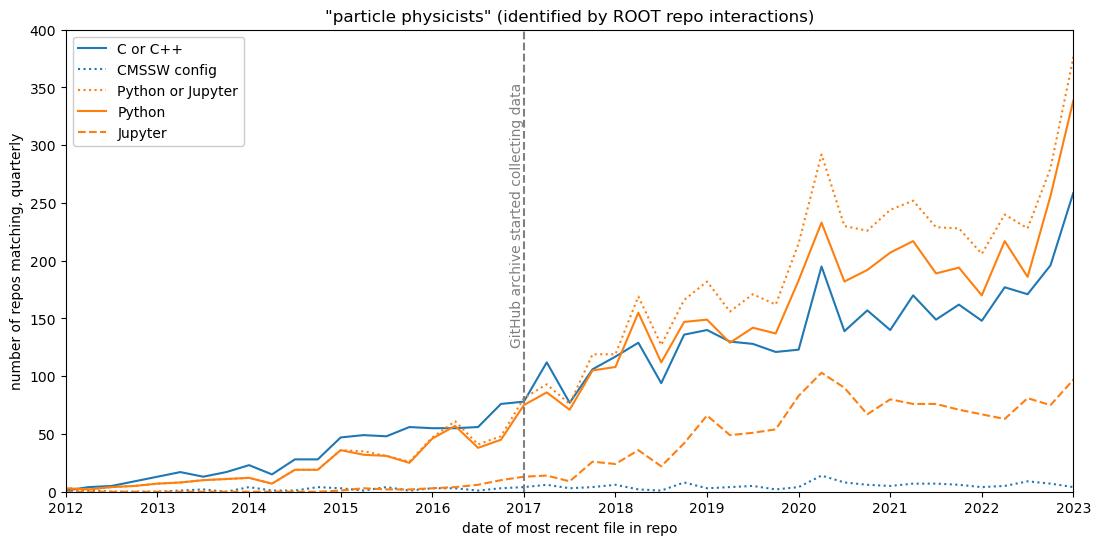

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df[["C or C++", "CMSSW config", "Python or Jupyter", "Python", "Jupyter"]].resample("Q", origin=pd.to_datetime("2013-01-01")).sum().plot(
    ax=ax,
    style=["-", ":", ":", "-", "--"],
    color=[c[0], c[0], c[1], c[1], c[1]],
);

ax.axvline(x=pd.to_datetime("2017-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2017-01-01"), 0.6, "GitHub archive started collecting data",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 400);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_xlabel("date of most recent file in repo");
ax.set_ylabel("number of repos matching, quarterly");
ax.set_title("\"particle physicists\" (identified by ROOT repo interactions)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-language-rootseed.svg");
fig.savefig("github-language-rootseed.pdf");

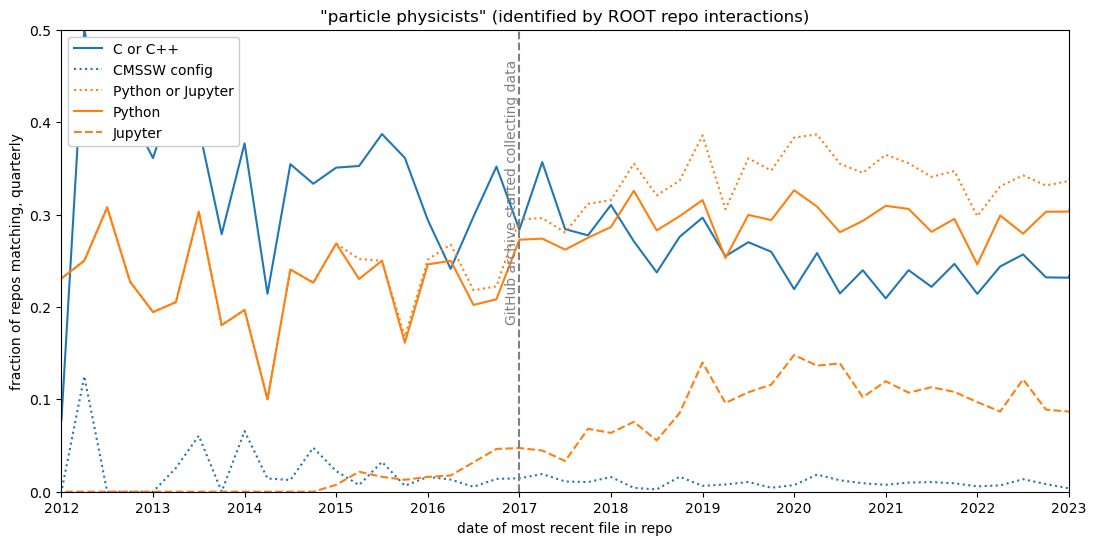

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df2 = df[["C or C++", "CMSSW config", "Python or Jupyter", "Python", "Jupyter", "Total"]].resample("Q", origin=pd.to_datetime("2013-01-01")).sum()
df2.div(df2["Total"], axis=0)[["C or C++", "CMSSW config", "Python or Jupyter", "Python", "Jupyter"]].plot(
    ax=ax,
    style=["-", ":", ":", "-", "--"],
    color=[c[0], c[0], c[1], c[1], c[1]],
);

ax.axvline(x=pd.to_datetime("2017-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2017-01-01"), 0.65, "GitHub archive started collecting data",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 0.5);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_xlabel("date of most recent file in repo");
ax.set_ylabel("fraction of repos matching, quarterly");
ax.set_title("\"particle physicists\" (identified by ROOT repo interactions)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-language-rootseed-fraction.svg");
fig.savefig("github-language-rootseed-fraction.pdf");

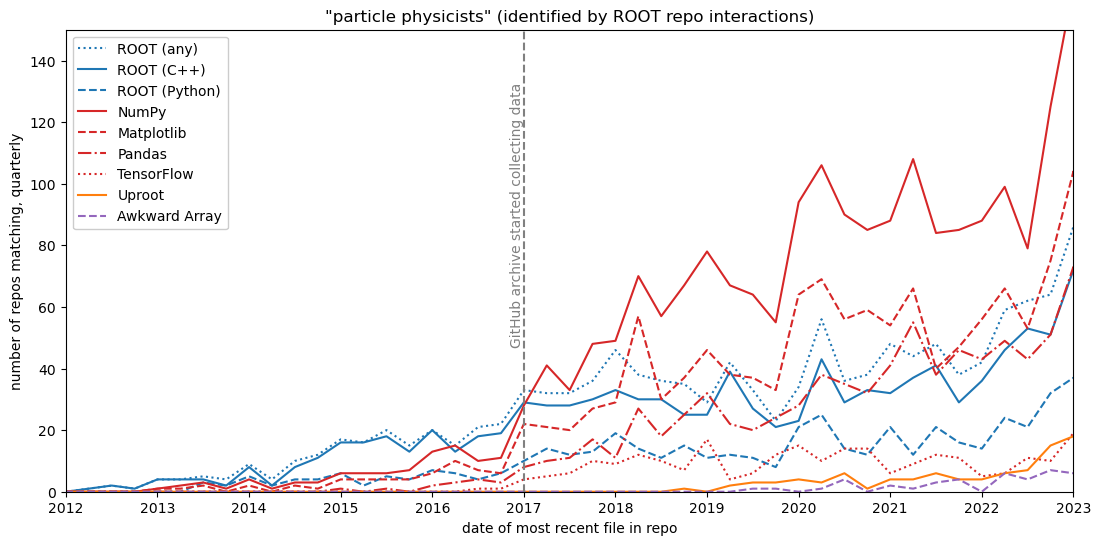

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df[["ROOT (any)", "ROOT (C++)", "ROOT (Python)", "NumPy", "Matplotlib", "Pandas", "TensorFlow", "Uproot", "Awkward Array"]].resample("Q", origin=pd.to_datetime("2013-01-01")).sum().plot(
    ax=ax,
    style=[":", "-", "--", "-", "--", "-.", ":", "-", "--"],
    color=[c[0], c[0], c[0], c[3], c[3], c[3], c[3], c[1], c[4]],
);

ax.axvline(x=pd.to_datetime("2017-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2017-01-01"), 0.6, "GitHub archive started collecting data",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 150);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_ylabel("number of repos matching, quarterly");
ax.set_xlabel("date of most recent file in repo");
ax.set_title("\"particle physicists\" (identified by ROOT repo interactions)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-package-rootseed.svg");
fig.savefig("github-package-rootseed.pdf");

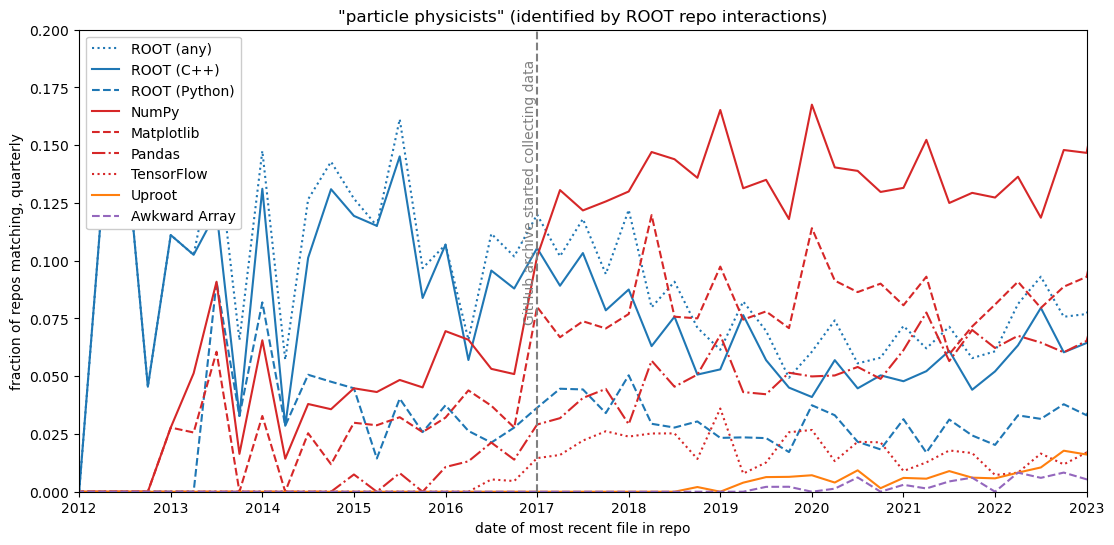

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df2 = df[["ROOT (any)", "ROOT (C++)", "ROOT (Python)", "NumPy", "Matplotlib", "Pandas", "TensorFlow", "Uproot", "Awkward Array", "Total"]].resample("Q", origin=pd.to_datetime("2013-01-01")).sum()
df2.div(df2["Total"], axis=0)[["ROOT (any)", "ROOT (C++)", "ROOT (Python)", "NumPy", "Matplotlib", "Pandas", "TensorFlow", "Uproot", "Awkward Array"]].plot(
    ax=ax,
    style=[":", "-", "--", "-", "--", "-.", ":", "-", "--"],
    color=[c[0], c[0], c[0], c[3], c[3], c[3], c[3], c[1], c[4]],
);

ax.axvline(x=pd.to_datetime("2017-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2017-01-01"), 0.65, "GitHub archive started collecting data",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 0.2);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_ylabel("fraction of repos matching, quarterly");
ax.set_xlabel("date of most recent file in repo");
ax.set_title("\"particle physicists\" (identified by ROOT repo interactions)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-package-rootseed-fraction.svg");
fig.savefig("github-package-rootseed-fraction.pdf");

## Question 4

Can we use the bios for selection?

In [107]:
cmssw_bios = json.load(open("/home/jpivarski/storage/data/physicists/forks-of-cmssw-2023-02-13/cmssw-bios.json"))
root_bios = json.load(open("/home/jpivarski/storage/data/physicists/github-archive/root-repo-bios.json"))

In [110]:
len(cmssw_bios), len(root_bios)

(3680, 2824)

In [111]:
def none_or_empty(x):
    return x is None or x.strip() == ""

In [114]:
len([x for x in cmssw_bios if not none_or_empty(x["bio"])]), len([x for x in root_bios if not none_or_empty(x["bio"])])

(476, 900)

In [171]:
def select(x):
    if x is None or x.strip() == "":
        return False
    else:
        return re.search("(phys|analy|hep|particle|cern|cms|atlas|alice|lhc)", x, re.I) is not None

(
    100 * len([x for x in cmssw_bios if select(x["bio"])]) / len(cmssw_bios),
    100 * len([x for x in root_bios if select(x["bio"])]) / len(root_bios),
)

(7.690217391304348, 7.613314447592068)

In [172]:
cmssw_physicists = set(x["name"] for x in cmssw_bios if select(x["bio"]))
root_physicists = set(x["name"] for x in root_bios if select(x["bio"]))

len(cmssw_physicists), len(root_physicists)

(283, 215)

In [183]:
def calculate_library_adoption_by_repo(filename):
    # gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = []
    for reponame, repo in batch.items():
        username = reponame.split("/")[0]

        repo_date = datetime(1970, 1, 1, tzinfo=timezone.utc)
        for file, data in repo.items():
            try:
                file_date = datetime.strptime(data[0], "%Y-%m-%d %H:%M:%S %z")
            except ValueError:
                pass
            else:
                if file_date > repo_date:
                    repo_date = file_date

        if reponame not in cmssw_repo_exclude and username in cmssw_physicists:
            libraries = libraries_in_repo(cmssw_repo_dir, reponame)
            repo = {"date": repo_date, "name": reponame}
            repo["py"] = any(x.startswith("py:") for x in libraries)
            repo["ipynb"] = any(x.startswith("PY:") for x in libraries)
            repo["cms"] = any(x.startswith("cms:") for x in libraries)
            repo["c"] = any(x.startswith("c:") for x in libraries)
            repo["c:ROOT"] = is_root(libraries)
            repo["py:ROOT"] = "py:ROOT" in libraries
            repo["py:uproot"] = "py:uproot" in libraries or "py:uproot3" in libraries or "py:uproot4" in libraries
            repo["py:awkward"] = "py:awkward" in libraries or "py:awkward0" in libraries or "py:awkward1" in libraries
            repo["py:numpy"] = "py:numpy" in libraries
            repo["py:matplotlib"] = "py:matplotlib" in libraries
            repo["py:seaborn"] = "py:seaborn" in libraries
            repo["py:pandas"] = "py:pandas" in libraries
            repo["py:scipy"] = "py:scipy" in libraries
            repo["py:tensorflow"] = "py:tensorflow" in libraries
            repo["py:torch"] = "py:torch" in libraries
            repo["py:sklearn"] = "py:sklearn" in libraries
            out.append(repo)

    return out

In [184]:
batches = cmssw_file_ages_names.map(calculate_library_adoption_by_repo).compute()

In [185]:
repodata = sum(batches, [])

df = pd.DataFrame({
    "C or C++": [x["c"] for x in repodata],
    "Python": [x["py"] for x in repodata],
    "Jupyter": [x["ipynb"] for x in repodata],
    "CMSSW config": [x["cms"] for x in repodata],
    "ROOT (C++)": [x["c:ROOT"] for x in repodata],
    "ROOT (Python)": [x["py:ROOT"] for x in repodata],
    "Uproot": [x["py:uproot"] for x in repodata],
    "Awkward Array": [x["py:awkward"] for x in repodata],
    "NumPy": [x["py:numpy"] for x in repodata],
    "Matplotlib": [x["py:matplotlib"] for x in repodata],
    "Seaborn": [x["py:seaborn"] for x in repodata],
    "Pandas": [x["py:pandas"] for x in repodata],
    "SciPy": [x["py:scipy"] for x in repodata],
    "TensorFlow": [x["py:tensorflow"] for x in repodata],
    "PyTorch": [x["py:torch"] for x in repodata],
    "Scikit-Learn": [x["py:sklearn"] for x in repodata],
}, index=[x["date"] for x in repodata])
df["Total"] = True
df["Python or Jupyter"] = df["Python"] | df["Jupyter"]
df["ROOT (any)"] = df["ROOT (C++)"] | df["ROOT (Python)"]

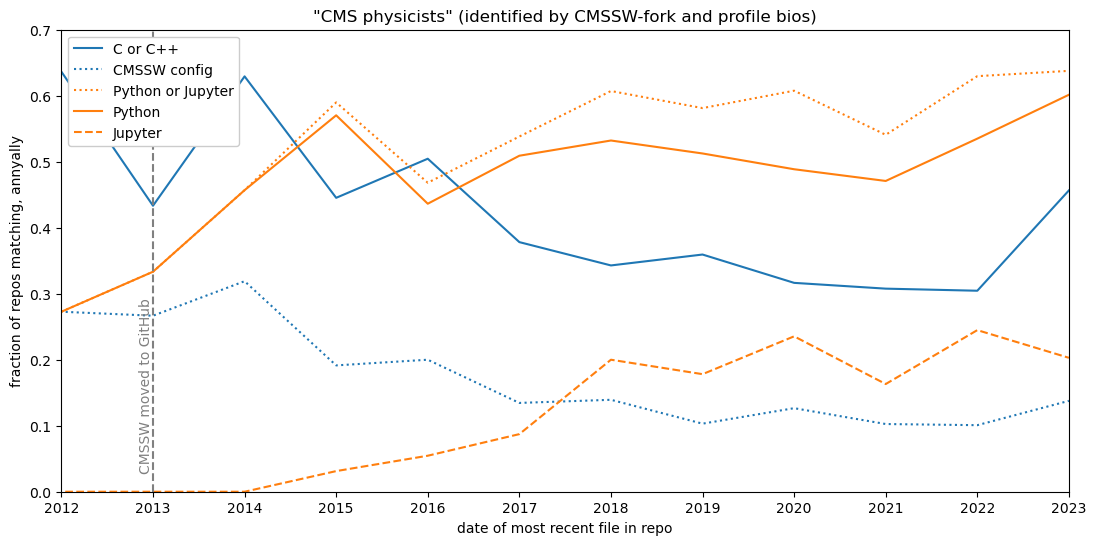

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df2 = df[["C or C++", "CMSSW config", "Python or Jupyter", "Python", "Jupyter", "Total"]].resample("Y", origin=pd.to_datetime("2013-01-01")).sum()
df2.div(df2["Total"], axis=0)[["C or C++", "CMSSW config", "Python or Jupyter", "Python", "Jupyter"]].plot(
    ax=ax,
    style=["-", ":", ":", "-", "--"],
    color=[c[0], c[0], c[1], c[1], c[1]],
);

ax.axvline(x=pd.to_datetime("2013-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2013-01-01"), 0.23, "CMSSW moved to GitHub",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 0.7);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_xlabel("date of most recent file in repo");
ax.set_ylabel("fraction of repos matching, annyally");
ax.set_title("\"CMS physicists\" (identified by CMSSW-fork and profile bios)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-language-cmsswseed-tight-fraction.svg");
fig.savefig("github-language-cmsswseed-tight-fraction.pdf");

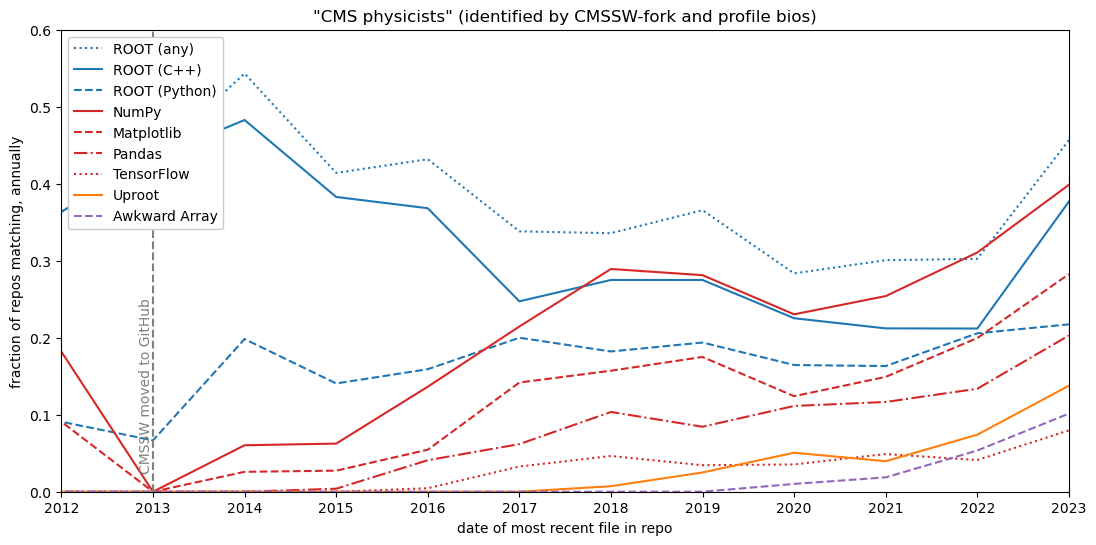

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df2 = df[["ROOT (any)", "ROOT (C++)", "ROOT (Python)", "NumPy", "Matplotlib", "Pandas", "TensorFlow", "Uproot", "Awkward Array", "Total"]].resample("Y", origin=pd.to_datetime("2013-01-01")).sum()

df2.div(df2["Total"], axis=0)[["ROOT (any)", "ROOT (C++)", "ROOT (Python)", "NumPy", "Matplotlib", "Pandas", "TensorFlow", "Uproot", "Awkward Array"]].plot(
    ax=ax,
    style=[":", "-", "--", "-", "--", "-.", ":", "-", "--"],
    color=[c[0], c[0], c[0], c[3], c[3], c[3], c[3], c[1], c[4]],
);

ax.axvline(x=pd.to_datetime("2013-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2013-01-01"), 0.23, "CMSSW moved to GitHub",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 0.6);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_ylabel("fraction of repos matching, annually");
ax.set_xlabel("date of most recent file in repo");
ax.set_title("\"CMS physicists\" (identified by CMSSW-fork and profile bios)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-package-cmsswseed-tight-fraction.svg");
fig.savefig("github-package-cmsswseed-tight-fraction.pdf");

In [188]:
def calculate_library_adoption_by_repo(filename):
    # gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = []
    for reponame, repo in batch.items():
        username = reponame.split("/")[0]

        repo_date = datetime(1970, 1, 1, tzinfo=timezone.utc)
        for file, data in repo.items():
            try:
                file_date = datetime.strptime(data[0], "%Y-%m-%d %H:%M:%S %z")
            except ValueError:
                pass
            else:
                if file_date > repo_date:
                    repo_date = file_date

        if reponame not in root_repo_exclude and username in root_physicists:
            libraries = libraries_in_repo(root_repo_dir, reponame)
            repo = {"date": repo_date, "name": reponame}
            repo["py"] = any(x.startswith("py:") for x in libraries)
            repo["ipynb"] = any(x.startswith("PY:") for x in libraries)
            repo["cms"] = any(x.startswith("cms:") for x in libraries)
            repo["c"] = any(x.startswith("c:") for x in libraries)
            repo["c:ROOT"] = is_root(libraries)
            repo["py:ROOT"] = "py:ROOT" in libraries
            repo["py:uproot"] = "py:uproot" in libraries or "py:uproot3" in libraries or "py:uproot4" in libraries
            repo["py:awkward"] = "py:awkward" in libraries or "py:awkward0" in libraries or "py:awkward1" in libraries
            repo["py:numpy"] = "py:numpy" in libraries
            repo["py:matplotlib"] = "py:matplotlib" in libraries
            repo["py:seaborn"] = "py:seaborn" in libraries
            repo["py:pandas"] = "py:pandas" in libraries
            repo["py:scipy"] = "py:scipy" in libraries
            repo["py:tensorflow"] = "py:tensorflow" in libraries
            repo["py:torch"] = "py:torch" in libraries
            repo["py:sklearn"] = "py:sklearn" in libraries
            out.append(repo)

    return out

In [189]:
batches = root_file_ages_names.map(calculate_library_adoption_by_repo).compute()

In [190]:
repodata = sum(batches, [])

df = pd.DataFrame({
    "C or C++": [x["c"] for x in repodata],
    "Python": [x["py"] for x in repodata],
    "Jupyter": [x["ipynb"] for x in repodata],
    "CMSSW config": [x["cms"] for x in repodata],
    "ROOT (C++)": [x["c:ROOT"] for x in repodata],
    "ROOT (Python)": [x["py:ROOT"] for x in repodata],
    "Uproot": [x["py:uproot"] for x in repodata],
    "Awkward Array": [x["py:awkward"] for x in repodata],
    "NumPy": [x["py:numpy"] for x in repodata],
    "Matplotlib": [x["py:matplotlib"] for x in repodata],
    "Seaborn": [x["py:seaborn"] for x in repodata],
    "Pandas": [x["py:pandas"] for x in repodata],
    "SciPy": [x["py:scipy"] for x in repodata],
    "TensorFlow": [x["py:tensorflow"] for x in repodata],
    "PyTorch": [x["py:torch"] for x in repodata],
    "Scikit-Learn": [x["py:sklearn"] for x in repodata],
}, index=[x["date"] for x in repodata])
df["Total"] = True
df["Python or Jupyter"] = df["Python"] | df["Jupyter"]
df["ROOT (any)"] = df["ROOT (C++)"] | df["ROOT (Python)"]

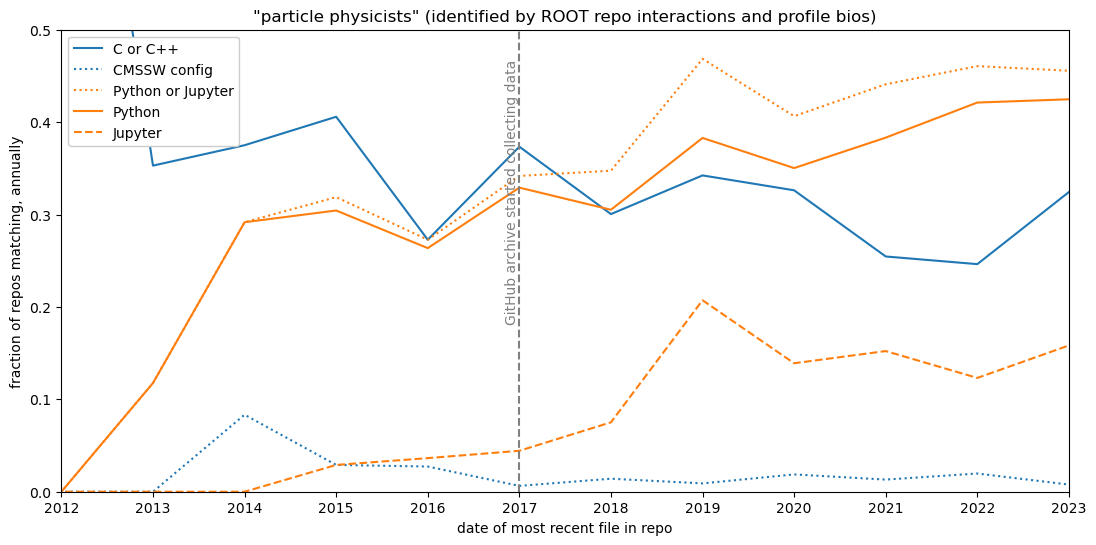

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df2 = df[["C or C++", "CMSSW config", "Python or Jupyter", "Python", "Jupyter", "Total"]].resample("Y", origin=pd.to_datetime("2013-01-01")).sum()
df2.div(df2["Total"], axis=0)[["C or C++", "CMSSW config", "Python or Jupyter", "Python", "Jupyter"]].plot(
    ax=ax,
    style=["-", ":", ":", "-", "--"],
    color=[c[0], c[0], c[1], c[1], c[1]],
);

ax.axvline(x=pd.to_datetime("2017-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2017-01-01"), 0.65, "GitHub archive started collecting data",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 0.5);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_xlabel("date of most recent file in repo");
ax.set_ylabel("fraction of repos matching, annually");
ax.set_title("\"particle physicists\" (identified by ROOT repo interactions and profile bios)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-language-rootseed-tight-fraction.svg");
fig.savefig("github-language-rootseed-tight-fraction.pdf");

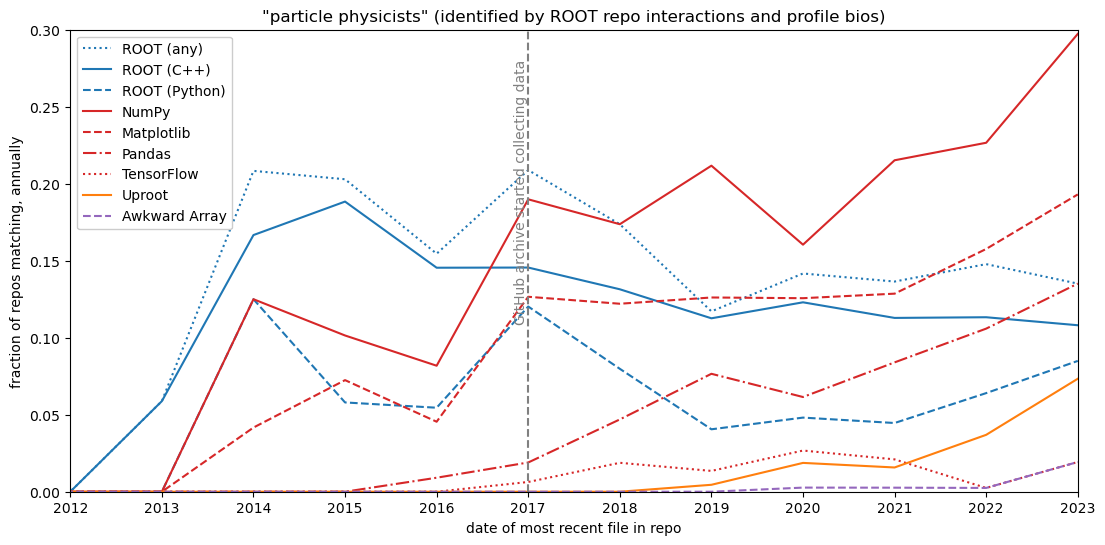

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df2 = df[["ROOT (any)", "ROOT (C++)", "ROOT (Python)", "NumPy", "Matplotlib", "Pandas", "TensorFlow", "Uproot", "Awkward Array", "Total"]].resample("Y", origin=pd.to_datetime("2013-01-01")).sum()
df2.div(df2["Total"], axis=0)[["ROOT (any)", "ROOT (C++)", "ROOT (Python)", "NumPy", "Matplotlib", "Pandas", "TensorFlow", "Uproot", "Awkward Array"]].plot(
    ax=ax,
    style=[":", "-", "--", "-", "--", "-.", ":", "-", "--"],
    color=[c[0], c[0], c[0], c[3], c[3], c[3], c[3], c[1], c[4]],
);

ax.axvline(x=pd.to_datetime("2017-01-01"), ls="--", c="gray")
ax.text(pd.to_datetime("2017-01-01"), 0.65, "GitHub archive started collecting data",
        transform=ax.get_xaxis_transform(), rotation=90, ha="right", va="center", c="gray")

ax.set_ylim(0, 0.3);
ax.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax.set_ylabel("fraction of repos matching, annually");
ax.set_xlabel("date of most recent file in repo");
ax.set_title("\"particle physicists\" (identified by ROOT repo interactions and profile bios)");
ax.legend(loc="upper left", facecolor="white", framealpha=1);

fig.savefig("github-package-rootseed-tight-fraction.svg");
fig.savefig("github-package-rootseed-tight-fraction.pdf");